Based on https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html 

In [1]:
import pandas as pd  # requires: pip install pandas
import torch
import numpy as np
import matplotlib.pyplot as plt
from chronos import ChronosPipeline

In [2]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [3]:
# Reading data from ag
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_tiny/train.csv")

In [4]:
df.head()

,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


### Data exploration

In [5]:
df.shape

(14000, 3)

In [6]:
df['target'].mean()

13089.021285714285

<Axes: xlabel='target', ylabel='Count'>

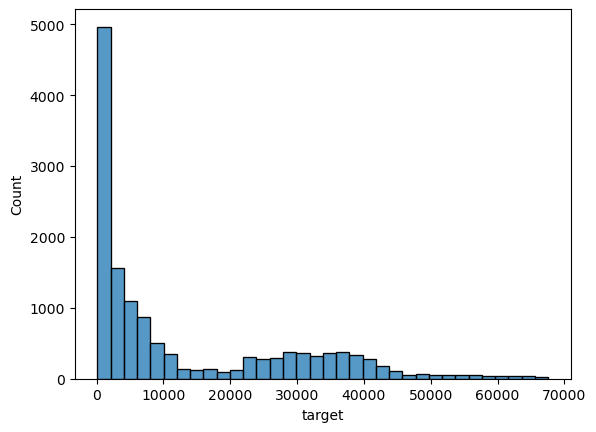

In [8]:
import seaborn as sns
sns.histplot(df['target'])#,kde = True, bins=50)

In [9]:
'''
Deviate from the normal distribution.
Have appreciable positive skewness.
Show peakedness.
'''
#skewness and kurtosis
print("Skewness: %f" % df['target'].skew())
print("Kurtosis: %f" % df['target'].kurt()) # positive show long tail , negative light tail

Skewness: 1.161583
Kurtosis: 0.221635


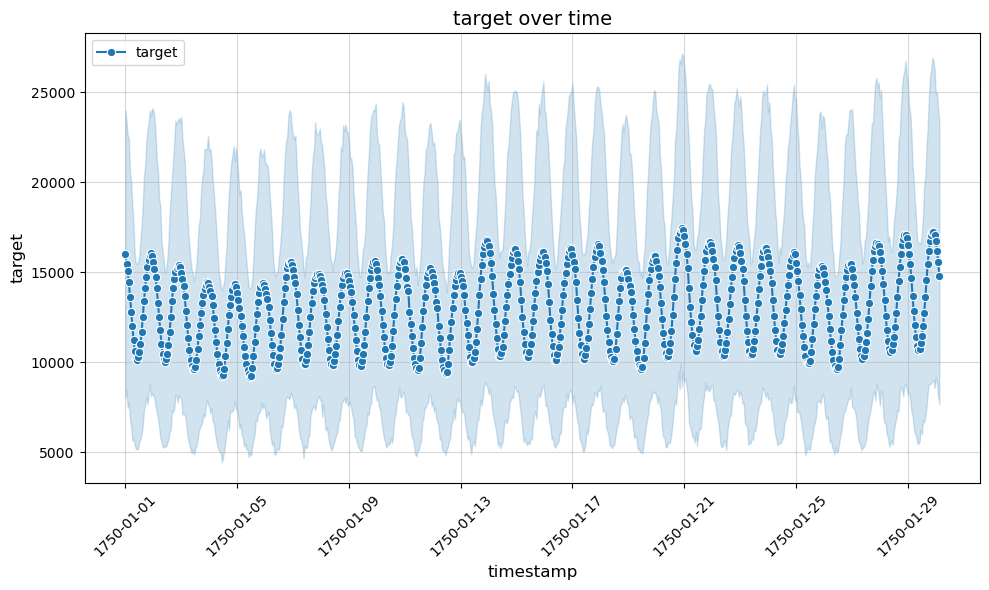

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='timestamp', y='target', marker='o', label='target')

# Add labels, title, and legend
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('target', fontsize=12)
plt.title('target over time', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.legend()
plt.grid(alpha=0.5)  # Add a light grid
plt.tight_layout()
plt.show()

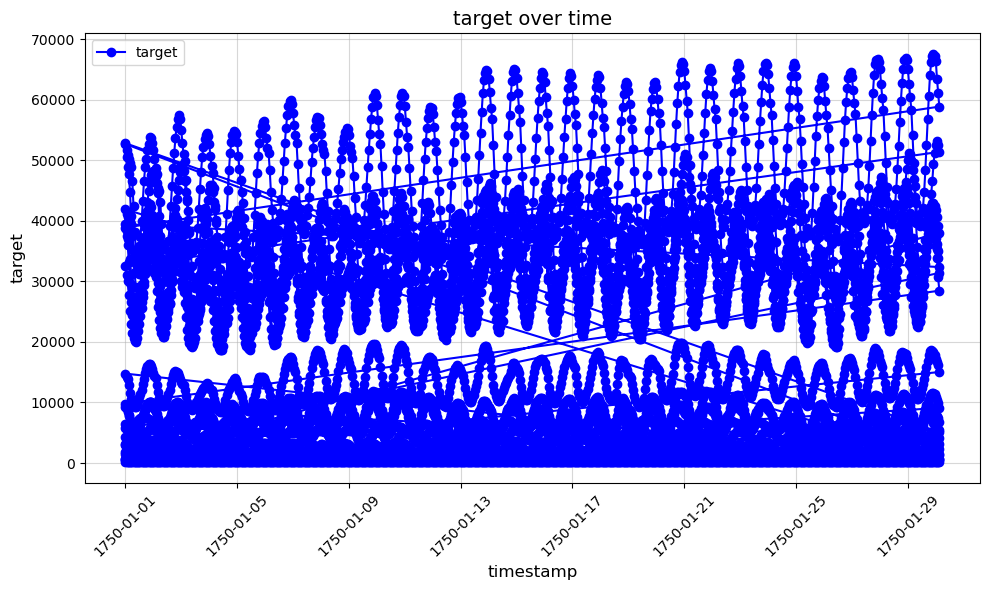

In [11]:
import matplotlib.pyplot as plt
df['timestamp'] = pd.to_datetime(df['timestamp']) # To see the time beter, in a range
# Plot data as a line plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(df['timestamp'], df['target'], marker='o', linestyle='-', color='b', label='target')

# Add labels, title, and legend
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('target', fontsize=12)
plt.title('target over time', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.grid(alpha=0.5)  # Add a light grid
plt.tight_layout()   # Adjust layout to prevent overlap
plt.show()

In [12]:
print(df.dtypes)

item_id              object
timestamp    datetime64[ns]
target              float64
dtype: object


In [13]:
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
print(correlation_matrix)

        target
target     1.0


In [16]:
# Convert 'timestamp' to datetime format and add a numeric column for the ordinal date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp_origin'] = df['timestamp'].map(lambda x: x.toordinal())

# Drop non-numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])
# Calculate and print the correlation matrix
correlation_matrix = numeric_df.corr()
print(correlation_matrix)

                    target  timestamp_origin
target            1.000000          0.023897
timestamp_origin  0.023897          1.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   item_id           14000 non-null  object        
 1   timestamp         14000 non-null  datetime64[ns]
 2   target            14000 non-null  float64       
 3   timestamp_origin  14000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 437.6+ KB


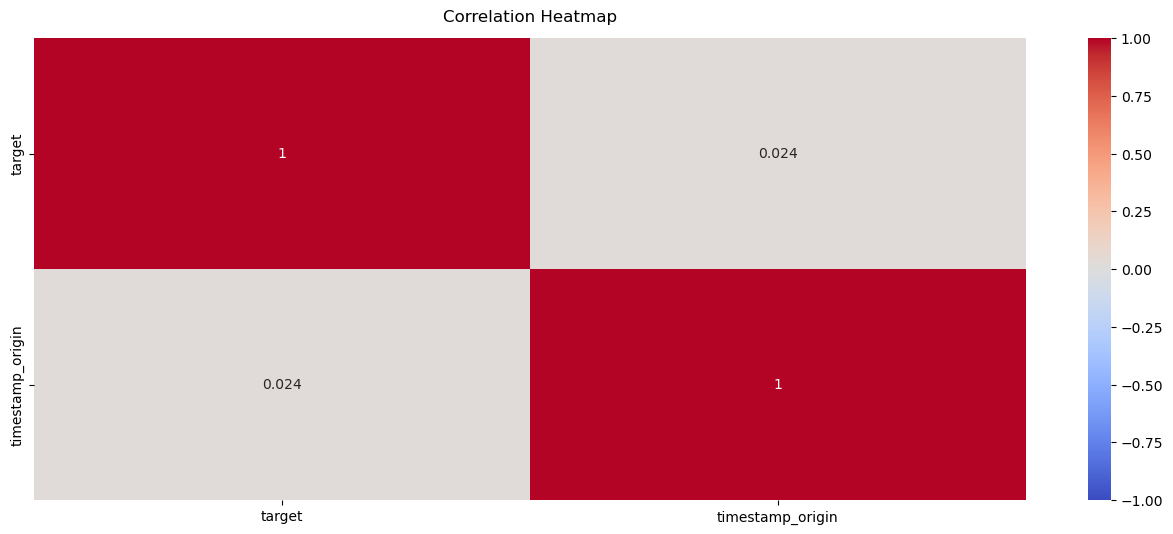

In [26]:
# Convert 'timestamp' to datetime format and add a numeric column for the ordinal date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp_origin'] = df['timestamp'].map(lambda x: x.toordinal())

# Drop non-numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric data
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

plt.show()


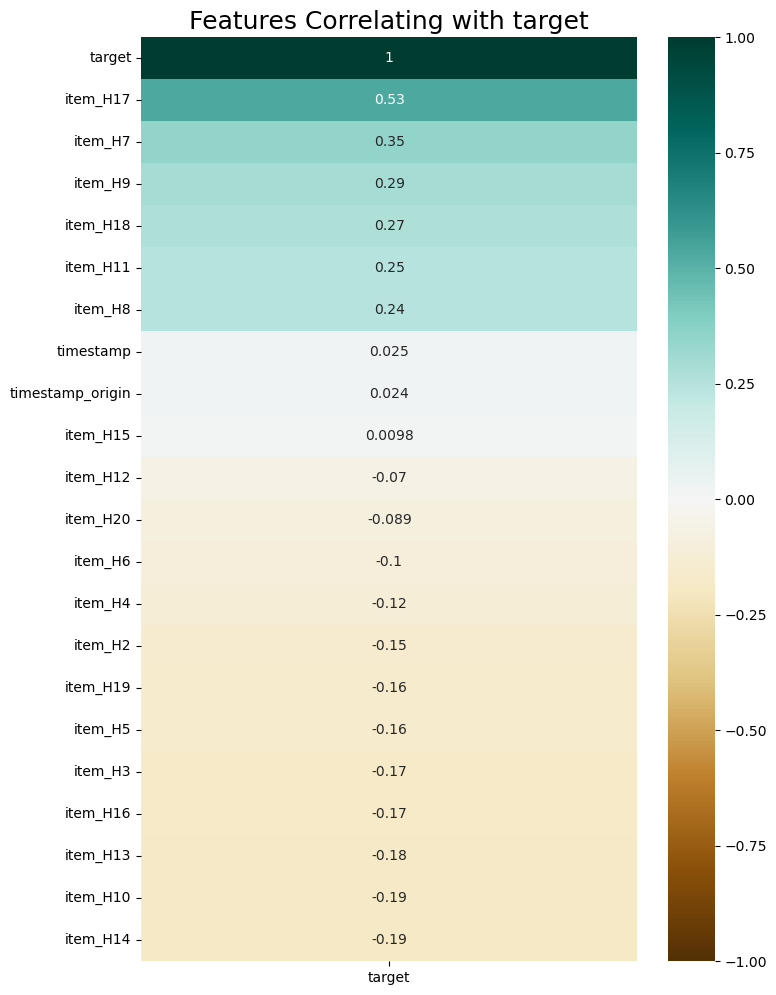

In [28]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with target', fontdict={'fontsize':18});
plt.show()

### Back to forcasting

In [29]:
len(df)

14000

In [31]:
len(df['target'])

14000

In [37]:
# Learning and predicting 
prediction_length = 24
forecast = pipeline.predict(
        context=torch.tensor(df["target"]), prediction_length = 24 #Specifies that the model should predict the next 12 time steps.
    )

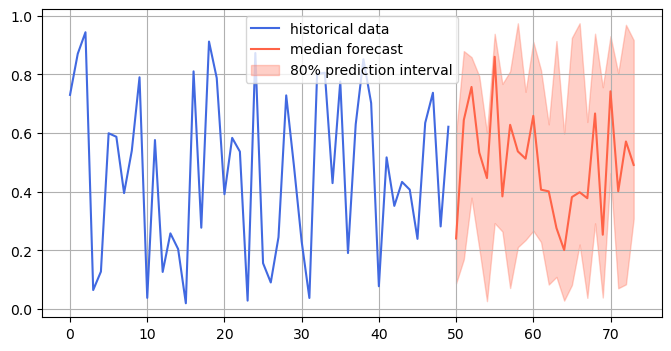

In [43]:
forecast = [np.random.rand(10, 24)]  # Example: random data for 24 time steps

# Assuming df is your DataFrame with a 'target' column
# Replace 'df' with your actual data
df = pd.DataFrame({"target": np.random.rand(50)})  # Example: historical data

# Define forecast_index
forecast_index = range(len(df), len(df) + forecast[0].shape[1])

# Calculate quantiles
low, median, high = np.quantile(forecast[0], [0.1, 0.5, 0.9], axis=0)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(df["target"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()